In [38]:
from google.colab import drive
drive.mount('/content/gdrive')


import os
import datetime
from math import cos, asin, sqrt, pow
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Flatten, RepeatVector, TimeDistributed, Masking
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import tensorflow as tf  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Models and datasets dirs
DATASETS_DIR = r'/content/gdrive/My Drive/datasets/'
MODEL_FOLDER = 'classification/'
MODELS_DIR = DATASETS_DIR + MODEL_FOLDER



In [0]:
def display_lr(lr_schedule, nb_epochs):
  x = np.arange(nb_epochs)
  y = [lr_schedule(i) for i in x]
  plt.figure(figsize=(9,5))
  plt.plot(x,y)
  plt.title("Learning rate schedule\nmax={:.2e}, min={:.2e}".format(np.max(y), np.min(y)),
            y=0.85)
  plt.show()

def display_loss(history, full_history, nb_epochs, steps_per_epoch):
  plt.figure()
  plt.plot(np.arange(0, len(full_history['loss']))/steps_per_epoch, full_history['loss'], label='detailed loss')
  plt.plot(np.arange(1, nb_epochs+1), history['loss'], color='red', linewidth=3, label='average loss per epoch')
  plt.ylim(0,3*max(history['loss'][1:]))
  plt.xlabel('EPOCH')
  plt.ylabel('LOSS')
  plt.xlim(0, nb_epochs+0.5)
  plt.legend()
  for epoch in range(nb_epochs//2+1):
    plt.gca().axvspan(2*epoch, 2*epoch+1, alpha=0.05, color='grey')
  plt.show()



In [0]:
cadastro_estacoes = pd.read_csv(DATASETS_DIR + r'cadastro_estacoes.csv')
dados_estacoes = []
for i,row in cadastro_estacoes.iterrows():
    dados_estacao = pd.read_csv(DATASETS_DIR + r'estacao_{0}.csv'.format(row['id']),delimiter=';')
    dados_estacao['datahora'] = pd.to_datetime(dados_estacao['Data'],format='%d/%m/%Y')
    dados_estacao.index = pd.to_datetime(dados_estacao['datahora'])
    new_column_name = f"Precipitacao_{row['id']}"
    dados_estacao = dados_estacao.rename(columns = {'Precipitacao':new_column_name})
    dados_estacoes.append(dados_estacao[['datahora',new_column_name]])
    
dados_estacoes = pd.concat(dados_estacoes, axis=1)
dados_estacoes = dados_estacoes.drop(columns=['datahora',])
dados_estacoes = dados_estacoes.fillna(0)

#dados_estacoes
#Precipitacao_83533	Precipitacao_83536	Precipitacao_83570	Precipitacao_83581	Precipitacao_83586	Precipitacao_83587	Precipitacao_83589	Precipitacao_83632	Precipitacao_83635

In [0]:
#carrega cadastro de elevatórias

cadastro_elevatorias = pd.read_csv(DATASETS_DIR + r'cadastro_elevatorias.csv',decimal=",")
cadastro_elevatorias['nivel_max'] = cadastro_elevatorias['nivel_max'].astype(float)
cadastro_elevatorias['corrente1_max'] = cadastro_elevatorias['corrente1_max'].astype(float)
cadastro_elevatorias['corrente2_max'] = cadastro_elevatorias['corrente2_max'].astype(float)
cadastro_elevatorias['corrente3_max'] = cadastro_elevatorias['corrente3_max'].astype(float)

cadastro_sem_strings = cadastro_elevatorias.copy()

tmp = cadastro_sem_strings.select_dtypes(exclude=[np.number])

# integer encode
label_encoder = LabelEncoder()
for column in tmp.columns:
    integer_encoded = label_encoder.fit_transform(tmp[column])
    cadastro_sem_strings[column] = integer_encoded

In [43]:
#imprime indices das elevatorias com tipo de bomba autoescorvante
cadastro_elevatorias[cadastro_elevatorias['Tipo de bomba'] == 'Autoescorvante']['indice'].values

array([ 1,  8, 13, 22, 24, 25])

In [0]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
HOURS_BEFORE = 8
HOURS_AFTER  = 1

def getTimeseriesFromElevatoria(elevatoria, years=None):
  timeseries_file   = DATASETS_DIR + f'timeseries_elevatoria_{elevatoria}.csv'
  #realiza leitura de arquivo csv, configura frequencia, renomeia coluna e cria coluna de data para deixar identico ao timeseries original
  timeseries   = pd.read_csv(timeseries_file, parse_dates=['TIMESTAMP','TIMESTAMP.1', 'TIMESTAMP_fim'], index_col=0)
  timeseries = timeseries.rename(columns={'TIMESTAMP.1': 'TIMESTAMP',}).asfreq('5T')
  timeseries['DATA'] = timeseries.index.date
  
  if years != None:
    timeseries = timeseries[timeseries.TIMESTAMP.dt.year.isin(years)]
  
  #calcula soma do tempo de extravasao para a proxima 1h (12x5 minutos)
  timeseries['extravasao_duracao_after'] = timeseries['extravasao_duracao'].rolling(min_periods=1, window=HOURS_AFTER*12).sum().shift(-HOURS_AFTER*12)
  timeseries['extravasao_duracao_before'] = timeseries['extravasao_duracao'].rolling(min_periods=1, window=HOURS_BEFORE*12).sum()

  #filtra apenas as que não tiveram extravasao nas ultimas 8h para garantir que a predição não é contaminada 
  #(prever a extravasão sem saber que há uma extravasão ocorrendo tem mais valor)
  #timeseries = timeseries[timeseries.extravasao_duracao_before == 0]
    
  create_features(timeseries)

  #cria coluna em dados de estacoes metereologicas e une dados a estacao
  dados_estacoes['DATA'] = dados_estacoes.index.date
  timeseries = pd.merge(timeseries, dados_estacoes,on='DATA')    
    
  #varre cada uma das colunas do cadastro criando novas colunas (categorical data) na serie temporal
  for column in cadastro_sem_strings.columns:
    timeseries[column] = cadastro_sem_strings.iloc[elevatoria - 1][column]

  #conta quantidade de valores nulos nas proximas 8h  
  timeseries['isnull']          = 0
  timeseries.loc[timeseries.nivel.isnull(), 'isnull'] = 1
  timeseries['contagem_valores_nulos_prox_8h']          = timeseries['isnull'].rolling(min_periods=1, window=8*12).sum().shift(8*12)    
    
  #marca valores nan com -1
  #timeseries = timeseries.fillna(-1)
  
  #seta valor de colunas de saida = 0 caso valor seja menor que 0
  #timeseries.loc[timeseries['extravasao_duracao_after'] < 0, 'extravasao_duracao_after'] = 0.0
  #timeseries.loc[timeseries['extravasao_duracao_before'] < 0, 'extravasao_duracao_before'] = 0.0
  
  
  #converte valor das colunas de duracao para horas
  for col in timeseries.columns:
    if 'duracao' in col:
      #transforma para horas
      timeseries[col] = timeseries[col] * 1.0/ 3600
  
  
  #remove linhas em que, ao menos metade das 8h proximas, possuem valor nulo
  #timeseries = timeseries[timeseries.contagem_valores_nulos_prox_8h < 48]

  return timeseries 


In [0]:
# multivariate output data prep


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

 

def prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps = 96):
    """
    prepara serie temporal para fit do modelo
    n_steps com valor defaul de 96 considerando 8 horas (12 registros de 5min/hora => 12*8)
    """
    #tamanho dos vetores
    size_of_arrays = len(timeseries.index)

    #sequencias de entradas e saídas convertidas em estruturas de [linhas, colunas]
    in_seqs  = [timeseries[col].values.reshape((size_of_arrays, 1)) for col in input_columns]
    out_seqs = [timeseries[col].values.reshape((size_of_arrays, 1)) for col in output_columns]

    # horizontally stack columns
    dataset = np.hstack(tuple(in_seqs + out_seqs))


    # convert into input/output
    X, y = split_sequences(dataset, n_steps)

    return X, y

#cria lista de nomes de colunas sem saida
output_columns    = ['tipo_extravasao',]
columns_to_remove = ['DATA','TIMESTAMP','TIMESTAMP_fim','date', 'nivel_inv_max', 'corrente1_inv_max', 
                     'corrente2_inv_max', 'corrente3_inv_max', 'extravasao_ocorreu', 'extravasao_ocorrendo', 
                    'acc_bomba1_ocorreu', 'acc_bomba1_ocorrendo', 'acc_bomba2_ocorreu', 'acc_bomba2_ocorrendo',
                    'acc_bomba3_ocorreu', 'acc_bomba3_ocorrendo','mnt_bomba1_ocorreu', 'mnt_bomba1_ocorrendo',
                    'mnt_bomba2_ocorreu', 'mnt_bomba2_ocorrendo', 'mnt_bomba3_ocorreu', 'mnt_bomba3_ocorrendo',
                     'extravasao_duracao_before','contagem_valores_nulos_prox_8h', 'isnull', 'extravasao_duracao_after',]
#input_columns     = [k for k in timeseries.columns if k not in output_columns + columns_to_remove]
input_columns = [
  'nivel', 'corrente1', 'corrente2', 'corrente3', 'extravasao_contagem', 
 'extravasao_duracao', 'extravasao_contagem_cum', 'extravasao_duracao_cum',
 'extravasao_ocorreu_cum', 'extravasao_ocorrendo_cum', 'acc_bomba1_contagem',
 'acc_bomba1_duracao', 'acc_bomba1_contagem_cum', 'acc_bomba1_duracao_cum',
 'acc_bomba1_ocorreu_cum', 'acc_bomba1_ocorrendo_cum', 'mnt_bomba1_contagem',
 'mnt_bomba1_duracao', 'mnt_bomba1_contagem_cum', 'mnt_bomba1_duracao_cum',
 'mnt_bomba1_ocorreu_cum', 'mnt_bomba1_ocorrendo_cum', 'acc_bomba2_contagem',
 'acc_bomba2_duracao', 'acc_bomba2_contagem_cum', 'acc_bomba2_duracao_cum',
 'acc_bomba2_ocorreu_cum', 'acc_bomba2_ocorrendo_cum', 'mnt_bomba2_contagem',
 'mnt_bomba2_duracao', 'mnt_bomba2_contagem_cum', 'mnt_bomba2_duracao_cum',
 'mnt_bomba2_ocorreu_cum', 'mnt_bomba2_ocorrendo_cum', 'acc_bomba3_contagem',
 'acc_bomba3_duracao', 'acc_bomba3_contagem_cum', 'acc_bomba3_duracao_cum',
 'acc_bomba3_ocorreu_cum', 'acc_bomba3_ocorrendo_cum', 'mnt_bomba3_contagem',
 'mnt_bomba3_duracao', 'mnt_bomba3_contagem_cum', 'mnt_bomba3_duracao_cum',
 'mnt_bomba3_ocorreu_cum', 'mnt_bomba3_ocorrendo_cum',
 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
 'weekofyear', 'Precipitacao_83581', 'Precipitacao_83570', 'Precipitacao_83536', 
 'Precipitacao_83533', 'Precipitacao_83635', 'Precipitacao_83632',
 'Precipitacao_83586', 'Precipitacao_83589', 'Precipitacao_83587',
 'indice', 'nome', 'utmx', 'utmy', 'Tipo de bomba', 'Quantidade de bombas', 
 'Vazão de recalque (l/s)', 'Altura manométrica (mca)', 
 'Diâmetro tubulação   recalque (mm)',  'Material  tubulação  recalque', 
 'Extensão  tubulação  recalque(m)', 'Retenção  resíduos', 
 'Sistema Içamento  bombas ', 'Urbanização', 'Potência instalada (cv)', 
 'Combate a odores', 'Sistema de partida das bombas',
 'Tipo de sensor de nível utilizado no controle', 'nivel_max', 
 'corrente1_max', 'corrente2_max', 'corrente3_max', 'bomba1', 'bomba2', 'bomba3']

valid_columns = input_columns + output_columns

#8 horas de dados
n_steps = 96
n_features = len(input_columns) # a quantidade de features está presente nas entradas
n_outputs  = 3 #opcoes de classificacao (sim, não e invalido)
n_batch    = n_steps #1 período de 8 horas



In [47]:
n_features

88

In [0]:

def get_timeseries_from_elevatoria(elevatoria, years):
  timeseries        = getTimeseriesFromElevatoria(elevatoria,years=years)
  timeseries['tipo_extravasao'] = 'nao'
  timeseries.loc[timeseries['extravasao_duracao_after'] > 0, 'tipo_extravasao'] = 'sim'
  timeseries.loc[timeseries.contagem_valores_nulos_prox_8h >= 48, 'tipo_extravasao'] = 'invalido'


  scaler_dict = {}

  #normaliza todas as colunas validas entre 0 e 1
  for column in input_columns:
    #values = timeseries[[column]].values
    min_max_scaler = MinMaxScaler()
    null_index = timeseries[column].isnull()
    timeseries.loc[~null_index, column] = min_max_scaler.fit_transform(timeseries.loc[~null_index, [column]])
    #timeseries[column] = min_max_scaler.fit_transform(values)
    scaler_dict[column] = min_max_scaler

  #marca valores nan com -1
  timeseries = timeseries.fillna(-1) 

  return timeseries 
  

In [0]:
def encode_output(train_y, test_y):
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(np.array(['nao', 'sim', 'invalido']))
  encoded_Y = encoder.transform(train_y)
  encoded_test_Y = encoder.transform(test_y)
  return to_categorical(encoder.transform(train_y)), \
          to_categorical(encoder.transform(test_y)),\
          encoded_Y,\
          encoded_test_Y

In [0]:
def dummy_prepare_input(input):
  """
  função dummy que não altera entrada
  """
  return input


prepare_function_by_model = {}
prepare_function_by_model['lstm100_vanilla'] = dummy_prepare_input


In [0]:
#dicionario de modelos
models = {}

model = Sequential()
model.add(LSTM(100, input_shape=(n_steps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
models['lstm100_vanilla'] = model

model_name = 'lstm100_vanilla'
model = models[model_name]

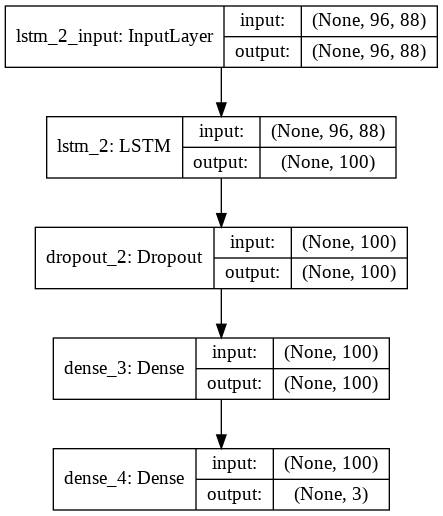

In [52]:
#imagem detalhando o modelo lstm100_vanilla
plot_model(model, to_file='model_lstm100_vanilla.png', show_shapes=True, show_layer_names=True)

In [0]:
# Keras model callbacks

# This callback records a per-step loss history instead of the average loss per
# epoch that Keras normally reports. It allows you to see more problems.
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.history = {'loss': []}
  def on_batch_end(self, batch, logs={}):
      self.history['loss'].append(logs.get('loss'))
      
# This callback resets the RNN state at each epoch
class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, batch, logs={}):
      self.model.reset_states()
      print('reset state')

reset_state = ResetStateCallback()
      
# learning rate decay callback
#def lr_schedule(epoch): return 0.01
def lr_schedule(epoch): return 0.0001 + 0.01 * pow(0.65, epoch)
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)


full_history = LossHistory()
'''
saves the model weights after each epoch if the validation loss decreased
'''
best_file_path = MODELS_DIR + f"best_{model_name}" +"_weights.{epoch:02d}-{val_loss:.hdf5}.h5"
checkpointer = ModelCheckpoint(filepath=best_file_path, verbose=1, save_best_only=True)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               75600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 86,003
Trainable params: 86,003
Non-trainable params: 0
_________________________________________________________________


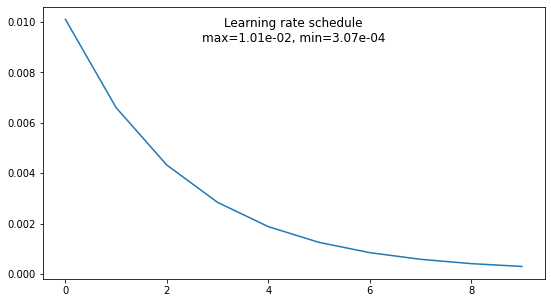

In [54]:
epoch = 1
NB_EPOCHS = 10
if epoch > 1:
  model.load_weights(MODELS_DIR + f"{model_name}_invclass_{elevatoria}_epoch{epoch - 1}_batch{n_batch}.h5")

# this prints a description of the model
model.summary()

display_lr(lr_schedule, NB_EPOCHS)



In [0]:
history_elevatorias = {}
epoch = 1

In [28]:
timeseries = get_timeseries_from_elevatoria(1, [2018,])
print(timeseries.shape)

#preparacao dos dados de treinamento e teste
train_x, train_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)
print(train_x.shape)
print(train_y.shape)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(train_y, train_y)
print(train_y.shape)
print(test_y.shape)
print(encoded_Y.shape)
print(encoded_test_Y.shape)

prepare_input_function = prepare_function_by_model[model_name]
print(prepare_input_function(train_x).shape)


(8895, 115)
(8800, 96, 88)
(8800,)
(8800, 3)
(8800, 3)
(8800,)
(8800,)
(8800, 96, 88)


In [0]:
elevatorias_escolhidas = [1, 22, 25] #apenas autoescorvantes
#elevatorias_escolhidas = [1,10,11,12,25] #vários tipos de bombas
epoch = 0
for nepoch in range(NB_EPOCHS):
  epoch +=1
  for year in [2016,2017,2018]:
    print(f'Epoca {epoch} - ano {year}')      
    for elevatoria in elevatorias_escolhidas:
      print(f'Treinando dados da elevatoria {elevatoria}...')
      timeseries = get_timeseries_from_elevatoria(elevatoria, [year,])

      #preparacao dos dados de treinamento e teste
      train_x, train_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

      #encode for classification task
      train_y, test_y, encoded_Y, encoded_test_Y = encode_output(train_y, train_y)
      
      full_history = LossHistory()
      
      # fit network
      number_of_epochs = NB_EPOCHS
      prepare_input_function = prepare_function_by_model[model_name]
      history  = model.fit(prepare_input_function(train_x), 
                          train_y, 
                          batch_size=n_batch, 
                          epochs=1, 
                          #validation_data=(prepare_input_function(test_x), encoded_test_Y), 
                          verbose=1,
                          callbacks=[full_history,])
      model.save(MODELS_DIR + f"{model_name}_{elevatoria}_epoch{epoch}_batch{n_batch}_{year}_complete_1htest_autoescorvantes.h5")
      try:
        history_elevatorias[elevatoria]['history'].append(history)
        history_elevatorias[elevatoria]['full_history'].append(full_history)
      except:
        history_elevatorias[elevatoria] = {}
        history_elevatorias[elevatoria]['history'] =[]
        history_elevatorias[elevatoria]['history'] = [history,]
        history_elevatorias[elevatoria]['full_history'] =[]
        history_elevatorias[elevatoria]['full_history'] = [full_history,]
        pass
      test_y = None
      test_x = None
      train_x = None
      train_y = None
      train = None
      test = None
      timeseries = None
      encoded_Y = None
      encoded_test_Y = None
      import gc
      gc.collect()


Epoca 1 - ano 2016
Treinando dados da elevatoria 1...
Epoch 1/1
105313/105313 [==============================] - 168s 2ms/step - loss: 0.1642 - acc: 0.9587
Treinando dados da elevatoria 22...
Epoch 1/1
105313/105313 [==============================] - 167s 2ms/step - loss: 0.2076 - acc: 0.9397
Treinando dados da elevatoria 25...
Epoch 1/1
105313/105313 [==============================] - 167s 2ms/step - loss: 0.1816 - acc: 0.9495
Epoca 1 - ano 2017
Treinando dados da elevatoria 1...
Epoch 1/1
105025/105025 [==============================] - 167s 2ms/step - loss: 0.1707 - acc: 0.9592
Treinando dados da elevatoria 22...
Epoch 1/1
105025/105025 [==============================] - 172s 2ms/step - loss: 0.1443 - acc: 0.9623
Treinando dados da elevatoria 25...
Epoch 1/1
105025/105025 [==============================] - 168s 2ms/step - loss: 0.1836 - acc: 0.9449
Epoca 1 - ano 2018
Treinando dados da elevatoria 1...
Epoch 1/1
8800/8800 [==============================] - 14s 2ms/step - loss: 0.0949

In [0]:
year = 2018
epoch = 10
elevatoria = 25

model.load_weights(MODELS_DIR + f"{model_name}_{elevatoria}_epoch{epoch}_batch{n_batch}_{year}_complete_1htest_autoescorvantes.h5")

In [0]:
import sklearn.metrics as skm
def print_accuracy_and_confusion_matrix(model, test_x, test_y, encoded_test_y, n_batch):
  loss , accuracy = model.evaluate(test_x, encoded_test_y, batch_size=n_batch, verbose=1)
  print('loss: {}   - accuracy: {} '.format(loss,accuracy))

  predicted = model.predict(test_x, verbose=0)
  y_pred= (predicted>0.5) 
  cm = skm.multilabel_confusion_matrix(test_y, y_pred)
  print(cm)
  print(skm.classification_report(test_y,y_pred))


test_y = None
test_x = None
train_x = None
train_y = None
train = None
test = None
timeseries = None
encoded_Y = None
encoded_test_Y = None
import gc
gc.collect()


timeseries = get_timeseries_from_elevatoria(13, [2016,2017,2018])

#preparacao e separacao dos dados 
test_x, test_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(test_y, test_y)

print_accuracy_and_confusion_matrix(model, test_x, test_y, test_y, n_batch)

predicted = model.predict(test_x, verbose=0)

con = tf.math.confusion_matrix(labels=encoded_Y, predictions=np.argmax(predicted, axis=1) )
tf.print(con)

from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Inválidos', 'Não', 'Sim']
print(classification_report(encoded_Y, np.argmax(predicted, axis=1), target_names=target_names))
print(confusion_matrix(encoded_Y, np.argmax(predicted, axis=1)))

In [57]:
print_accuracy_and_confusion_matrix(model, test_x, test_y, test_y, n_batch)

269767/269767 [==============================] - 146s 540us/step
loss: 0.14314081496763342   - accuracy: 0.9722908735275269 
[[[265777    573]
  [  1873   1544]]

 [[ 32798   4691]
  [  2249 230029]]

 [[233494   2201]
  [  3356  30716]]]
              precision    recall  f1-score   support

           0       0.73      0.45      0.56      3417
           1       0.98      0.99      0.99    232278
           2       0.93      0.90      0.92     34072

   micro avg       0.97      0.97      0.97    269767
   macro avg       0.88      0.78      0.82    269767
weighted avg       0.97      0.97      0.97    269767
 samples avg       0.97      0.97      0.97    269767



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
predicted = model.predict(test_x, verbose=0)

con = tf.math.confusion_matrix(labels=encoded_Y, predictions=np.argmax(predicted, axis=1) )
tf.print(con)

from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Inválidos', 'Não', 'Sim']
print(classification_report(encoded_Y, np.argmax(predicted, axis=1), target_names=target_names))
print(confusion_matrix(encoded_Y, np.argmax(predicted, axis=1)))

[[1546 1425 446]
 [491 230030 1757]
 [84 3272 30716]]
              precision    recall  f1-score   support

   Inválidos       0.73      0.45      0.56      3417
         Não       0.98      0.99      0.99    232278
         Sim       0.93      0.90      0.92     34072

    accuracy                           0.97    269767
   macro avg       0.88      0.78      0.82    269767
weighted avg       0.97      0.97      0.97    269767

[[  1546   1425    446]
 [   491 230030   1757]
 [    84   3272  30716]]


In [60]:
test_y = None
test_x = None
train_x = None
train_y = None
train = None
test = None
timeseries = None
encoded_Y = None
encoded_test_Y = None
import gc
gc.collect()


timeseries = get_timeseries_from_elevatoria(12, [2016,2017,2018])

#preparacao e separacao dos dados 
test_x, test_y = prepare_multivar_timeseries_tofit(timeseries, input_columns, output_columns, n_steps)

#encode for classification task
train_y, test_y, encoded_Y, encoded_test_Y = encode_output(test_y, test_y)

print_accuracy_and_confusion_matrix(model, test_x, test_y, test_y, n_batch)

predicted = model.predict(test_x, verbose=0)

con = tf.math.confusion_matrix(labels=encoded_Y, predictions=np.argmax(predicted, axis=1) )
tf.print(con)

from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Inválidos', 'Não', 'Sim']
print(classification_report(encoded_Y, np.argmax(predicted, axis=1), target_names=target_names))
print(confusion_matrix(encoded_Y, np.argmax(predicted, axis=1)))


269766/269766 [==============================] - 150s 557us/step
loss: 0.30854934025063896   - accuracy: 0.9212836027145386 
[[[262196   5372]
  [  1472    726]]

 [[ 48855   7692]
  [ 13313 199906]]

 [[207298   8119]
  [  6492  47857]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.12      0.33      0.18      2198
           1       0.96      0.94      0.95    213219
           2       0.85      0.88      0.87     54349

   micro avg       0.92      0.92      0.92    269766
   macro avg       0.65      0.72      0.66    269766
weighted avg       0.93      0.92      0.93    269766
 samples avg       0.92      0.92      0.92    269766

[[729 1397 72]
 [5226 199940 8053]
 [186 6301 47862]]
              precision    recall  f1-score   support

   Inválidos       0.12      0.33      0.17      2198
         Não       0.96      0.94      0.95    213219
         Sim       0.85      0.88      0.87     54349

    accuracy                           0.92    269766
   macro avg       0.65      0.72      0.66    269766
weighted avg       0.93      0.92      0.93    269766

[[   729   1397     72]
 [  5226 199940   8053]
 [   186   6301  47862]]
